In [1]:
import pandas as pd

import numpy as np
import itertools
import category_encoders as ce

from numpy import mean
from numpy import std
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [4]:
#df = pd.read_csv('bank updated.csv')              Old .csv with numeric pdays.

df = pd.read_csv('bank updated categories.csv')

col_names = ['age', 
             'job', 
             'martial', 
             'education', 
             'cred_in_default', 
             'balance',
             'housing',
             'loan',
             'contact',
             'last_contact_day',
             'last_contact_month',
             'last_contact_dur',
             'num_of_contacts_during_campaign',
             'past_days',
             'prev_contacts',
             'prev_outcome',
             'sub_term_deposit']
df.columns = col_names
df.head()

,age,job,martial,education,cred_in_default,balance,housing,loan,contact,last_contact_day,last_contact_month,last_contact_dur,num_of_contacts_during_campaign,past_days,prev_contacts,prev_outcome,sub_term_deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,No Contact,0,unknown,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,No Contact,0,unknown,no
2,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,No Contact,0,unknown,no
3,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,No Contact,0,unknown,no
4,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,No Contact,0,unknown,no


In [5]:
##Prep for MLP
print("Bank data set dimensions : {}".format(df.shape))

Bank data set dimensions : (4521, 17)


In [7]:
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
df = pd.read_csv('bank updated categories.csv')

# Define features and target
X = df[['age', 'job', 'marital', 'education', 'balance', 'housing',
        'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome']]
y = df['y'] 

# Define the columns to encode
cols_to_encode = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'pdays', 'poutcome']

# Filter cols_to_encode to include only those present in X
cols_to_encode = [col for col in cols_to_encode if col in X.columns]

# Extract column indices for encoding
col_indices = [X.columns.get_loc(col) for col in cols_to_encode]

# Create the encoder
encoder = OrdinalEncoder()
X_enc = X.copy()  # Make a copy of X
X_enc[cols_to_encode] = encoder.fit_transform(X[cols_to_encode])

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, stratify=y, random_state=3)


print("y_test set dimensions : {}".format(y_test.shape))

# Define the MLPClassifier
mlp = MLPClassifier(
    max_iter=200,
    alpha=0.1,
    activation='logistic',
    solver='adam')

# Fit the model to the training data
mlp.fit(X_enc, y)
mlp_predict = mlp.predict(X_enc)

y_test set dimensions : (1357,)


In [36]:
###Part B question B 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a range of number of neurons (k) and number of iterations
neurons_range = range(1, 26)  # From 1 to 25 neurons
iterations_range = [100, 200, 300, 400, 500] # Specify a range of iterations to test

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': [(k,) for k in neurons_range],  # Single hidden layer with k neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Best parameters:", best_params)
print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best iteration:", best_iter)

Classification Report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      1201
         yes       0.00      0.00      0.00       156

    accuracy                           0.89      1357
   macro avg       0.44      0.50      0.47      1357
weighted avg       0.78      0.89      0.83      1357

Best parameters: {'hidden_layer_sizes': (3,), 'max_iter': 300}
Best accuracy: 88.72%
Best iteration: 300


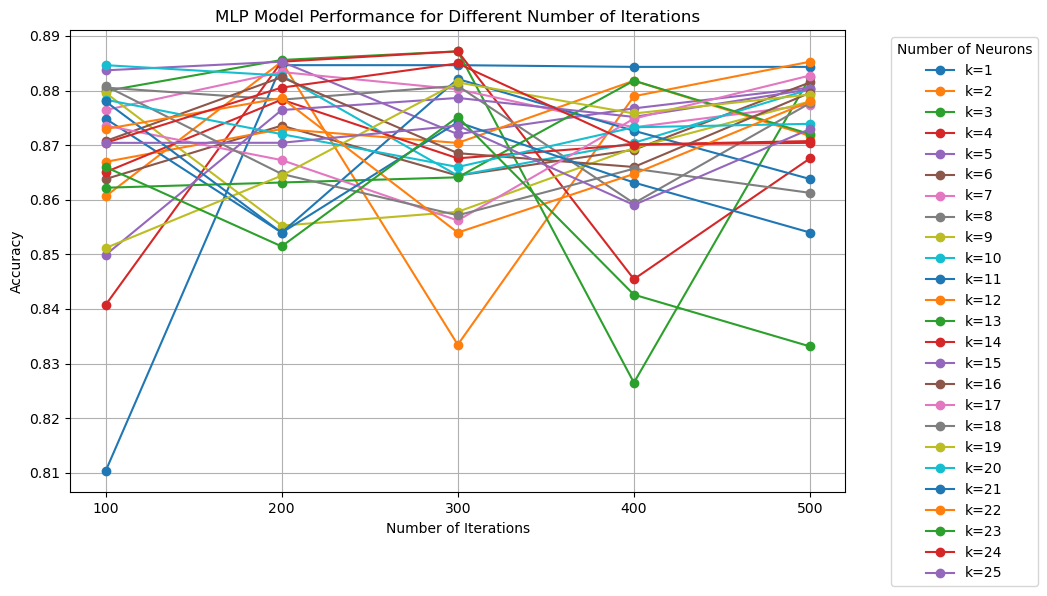

In [37]:
####Part B question B -  Plotting the accuracy for each number of iterations
results = grid_search.cv_results_
mean_test_scores = np.array([results['mean_test_score'][i::len(iterations_range)] for i in range(len(iterations_range))])

plt.figure(figsize=(10, 6))
for i, k in enumerate(neurons_range):
    plt.plot(iterations_range, mean_test_scores[:, i], marker='o', label=f'k={k}')

plt.title('MLP Model Performance for Different Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.xticks(iterations_range)
plt.legend(title='Number of Neurons', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Iteration 1: Training Loss = 13.4876, Test Loss = 4.0516
Iteration 2: Training Loss = 4.1469, Test Loss = 5.0731
Iteration 3: Training Loss = 2.5687, Test Loss = 1.3078
Iteration 4: Training Loss = 2.0093, Test Loss = 1.5225
Iteration 5: Training Loss = 2.1275, Test Loss = 0.9143
Iteration 6: Training Loss = 2.3489, Test Loss = 2.4190
Iteration 7: Training Loss = 2.5962, Test Loss = 2.3637
Iteration 8: Training Loss = 1.3094, Test Loss = 0.9191
Iteration 9: Training Loss = 2.5741, Test Loss = 1.9250
Iteration 10: Training Loss = 1.6631, Test Loss = 0.8318
Iteration 11: Training Loss = 1.7047, Test Loss = 1.3988
Iteration 12: Training Loss = 2.0125, Test Loss = 0.9752
Iteration 13: Training Loss = 2.1963, Test Loss = 2.3309
Iteration 14: Training Loss = 2.1530, Test Loss = 1.8261
Iteration 15: Training Loss = 1.5882, Test Loss = 1.1291
Iteration 16: Training Loss = 1.9510, Test Loss = 0.9964
Iteration 17: Training Loss = 1.9929, Test Loss = 1.6724
Iteration 18: Training Loss = 1.4802, T

Iteration 151: Training Loss = 1.6241, Test Loss = 1.0159
Iteration 152: Training Loss = 1.3435, Test Loss = 0.9772
Iteration 153: Training Loss = 1.8214, Test Loss = 0.9239
Iteration 154: Training Loss = 1.4884, Test Loss = 0.8169
Iteration 155: Training Loss = 1.3635, Test Loss = 0.9935
Iteration 156: Training Loss = 1.4798, Test Loss = 0.7021
Iteration 157: Training Loss = 1.3538, Test Loss = 0.9103
Iteration 158: Training Loss = 1.5438, Test Loss = 0.9035
Iteration 159: Training Loss = 1.2256, Test Loss = 0.6549
Iteration 160: Training Loss = 1.2805, Test Loss = 0.6427
Iteration 161: Training Loss = 1.2754, Test Loss = 0.7035
Iteration 162: Training Loss = 1.8884, Test Loss = 0.8282
Iteration 163: Training Loss = 1.3239, Test Loss = 0.8178
Iteration 164: Training Loss = 1.8287, Test Loss = 0.8139
Iteration 165: Training Loss = 1.4242, Test Loss = 0.9614
Iteration 166: Training Loss = 1.3202, Test Loss = 0.6886
Iteration 167: Training Loss = 0.9672, Test Loss = 1.2270
Iteration 168:

Iteration 296: Training Loss = 1.5695, Test Loss = 0.9009
Iteration 297: Training Loss = 1.0145, Test Loss = 1.1225
Iteration 298: Training Loss = 1.5251, Test Loss = 0.9930
Iteration 299: Training Loss = 1.0054, Test Loss = 1.1189
Iteration 300: Training Loss = 1.5673, Test Loss = 0.9131
Iteration 301: Training Loss = 1.1799, Test Loss = 1.1152
Iteration 302: Training Loss = 1.4826, Test Loss = 1.0896
Iteration 303: Training Loss = 1.0974, Test Loss = 1.2112
Iteration 304: Training Loss = 1.4966, Test Loss = 1.0324
Iteration 305: Training Loss = 1.0213, Test Loss = 1.1854
Iteration 306: Training Loss = 1.5337, Test Loss = 0.9704
Iteration 307: Training Loss = 1.0308, Test Loss = 1.1242
Iteration 308: Training Loss = 1.5490, Test Loss = 0.9404
Iteration 309: Training Loss = 1.2544, Test Loss = 0.9370
Iteration 310: Training Loss = 1.5723, Test Loss = 0.8938
Iteration 311: Training Loss = 0.9990, Test Loss = 1.1518
Iteration 312: Training Loss = 1.5508, Test Loss = 0.9632
Iteration 313:

Iteration 440: Training Loss = 1.5537, Test Loss = 1.0396
Iteration 441: Training Loss = 1.0791, Test Loss = 1.1567
Iteration 442: Training Loss = 1.5518, Test Loss = 1.0325
Iteration 443: Training Loss = 1.0703, Test Loss = 1.1272
Iteration 444: Training Loss = 1.5614, Test Loss = 1.0241
Iteration 445: Training Loss = 1.0720, Test Loss = 1.1503
Iteration 446: Training Loss = 1.5426, Test Loss = 1.0509
Iteration 447: Training Loss = 1.0791, Test Loss = 1.1492
Iteration 448: Training Loss = 1.5383, Test Loss = 1.0498
Iteration 449: Training Loss = 1.0333, Test Loss = 1.1448
Iteration 450: Training Loss = 1.5457, Test Loss = 1.0090
Iteration 451: Training Loss = 1.1683, Test Loss = 1.1787
Iteration 452: Training Loss = 1.5153, Test Loss = 1.1626
Iteration 453: Training Loss = 1.1001, Test Loss = 1.2535
Iteration 454: Training Loss = 1.5184, Test Loss = 1.1655
Iteration 455: Training Loss = 1.1680, Test Loss = 1.1342
Iteration 456: Training Loss = 1.5544, Test Loss = 1.0502
Iteration 457:

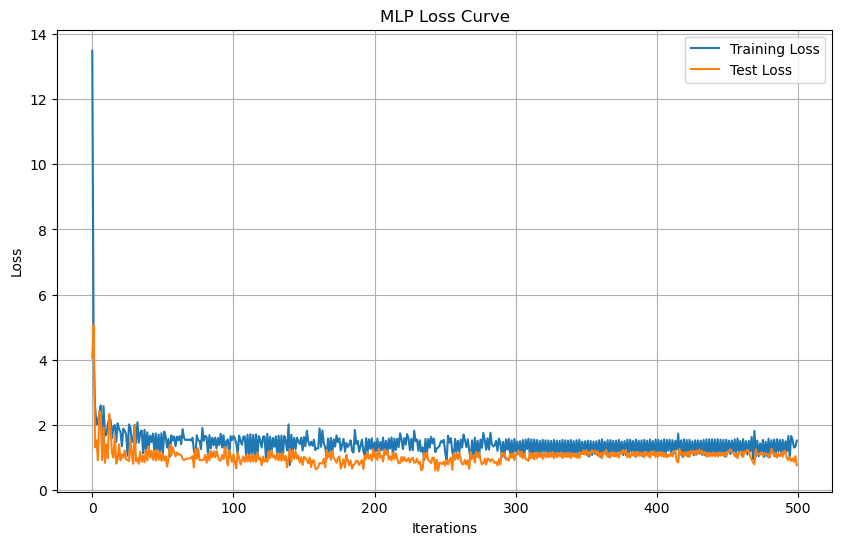

MLP Accuracy: 87.55%
MLP Classification Report:
              precision    recall  f1-score   support

          no       0.92      0.94      0.93      1201
         yes       0.45      0.35      0.39       156

    accuracy                           0.88      1357
   macro avg       0.68      0.65      0.66      1357
weighted avg       0.86      0.88      0.87      1357

MLP Training set score: 88.56%
MLP Testing set score: 87.55%


In [12]:
##Question c Part B
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Initialize variables to store the losses for each iteration
train_losses = []
test_losses = []

# Set the maximum number of iterations
max_iter = 500

# Create an MLPClassifier instance with warm_start=True to enable incremental fitting
mlp = MLPClassifier(max_iter=1, warm_start=True, verbose=False, random_state=42)

for i in range(max_iter):
    # Fit the model to the training data for one iteration
    mlp.fit(X_train, y_train)
    
    # Append the current training loss
    train_losses.append(mlp.loss_)
    
    # Calculate the loss on the test set
    y_pred_prob = mlp.predict_proba(X_test)
    test_loss = log_loss(y_test, y_pred_prob)  # Using log_loss function from scikit-learn
    test_losses.append(test_loss)
    
    # Print the loss for the current iteration
    print(f'Iteration {i+1}: Training Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}')

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('MLP Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the testing set after all iterations
mlp_predict = mlp.predict(X_test)

# Calculate MLP Accuracy
mlp_accuracy = accuracy_score(y_test, mlp_predict)

# MLP Classification report
mlp_classification_report = classification_report(y_test, mlp_predict)

# MLP Training set score
mlp_training_score = mlp.score(X_train, y_train)

# MLP Testing set score
mlp_testing_score = mlp.score(X_test, y_test)

# Print the accuracy and classification report
print(f'MLP Accuracy: {mlp_accuracy:.2%}')
print('MLP Classification Report:')
print(mlp_classification_report)
print(f'MLP Training set score: {mlp_training_score:.2%}')
print(f'MLP Testing set score: {mlp_testing_score:.2%}')

In [40]:
##Question d Part B
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a range of number of neurons (k)
neurons = 25  # Total number of neurons to be split between two layers
iterations_range = [100, 200, 300, 400, 500]  # Specify a range of iterations to test

# Generate combinations of neurons for two hidden layers
hidden_layer_sizes = [(k, neurons - k) for k in range(1, neurons)]

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': hidden_layer_sizes,  # Two hidden layers with varying neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

#print("Best parameters:", best_params)
#print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
#print("Best iteration:", best_iter)

In [41]:
#Question d part b continued.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from collections import defaultdict

# Define a range of number of neurons (k)
neurons = 25  # Total number of neurons to be split between two layers
iterations_range = [100, 200, 300, 400, 500]  # Specify a range of iterations to test

# Generate combinations of neurons for two hidden layers
hidden_layer_sizes = [(k, neurons - k) for k in range(1, neurons)]

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': hidden_layer_sizes,  # Two hidden layers with varying neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

#print("Best parameters:", best_params)
#print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
#print("Best iteration:", best_iter)

results = grid_search.cv_results_

# Initialize the dictionary to hold accuracies
accuracy_dict = defaultdict(list)

# Iterate over the results and populate the dictionary
for i in range(len(results['params'])):
    combination = results['params'][i]['hidden_layer_sizes']
    accuracy = results['mean_test_score'][i]
    accuracy_dict[combination].append(accuracy)

# Compute the mean accuracy for each combination
mean_accuracies = {k: sum(v) / len(v) for k, v in accuracy_dict.items()}

# Prepare the results table
results_table = [(k, v) for k, v in mean_accuracies.items()]

# Sort the results table by accuracy in descending order for better readability
results_table.sort(key=lambda x: x[1], reverse=True)

# Print the results table
print("\nResults Table in Order of Accuracy:")
print("{:<15} {:<10}".format('Combination', 'Accuracy'))
for row in results_table:
    print("{:<15} {:.2f}%".format(str(row[0]), row[1] * 100))


Results Table in Order of Accuracy:
Combination     Accuracy  
(22, 3)         88.40%
(1, 24)         88.31%
(4, 21)         88.19%
(3, 22)         87.95%
(15, 10)        87.93%
(5, 20)         87.90%
(6, 19)         87.90%
(8, 17)         87.86%
(20, 5)         87.78%
(7, 18)         87.67%
(9, 16)         87.53%
(19, 6)         87.52%
(21, 4)         87.49%
(2, 23)         87.41%
(10, 15)        87.25%
(18, 7)         86.86%
(13, 12)        86.78%
(17, 8)         86.74%
(12, 13)        86.74%
(16, 9)         86.69%
(11, 14)        86.59%
(14, 11)        86.21%
(24, 1)         85.30%
(23, 2)         85.25%


In [42]:
# Sort the results table by the first element of the combination (i.e., the number of neurons in the first hidden layer)
results_table.sort(key=lambda x: x[0][0])
# Print the results table
print("Results Table in Order of Combination:")
print("{:<15} {:<10}".format('Combination', 'Accuracy'))
for row in results_table:
    print("{:<15} {:.2f}%".format(str(row[0]), row[1] * 100))

Results Table in Order of Combination:
Combination     Accuracy  
(1, 24)         88.31%
(2, 23)         87.41%
(3, 22)         87.95%
(4, 21)         88.19%
(5, 20)         87.90%
(6, 19)         87.90%
(7, 18)         87.67%
(8, 17)         87.86%
(9, 16)         87.53%
(10, 15)        87.25%
(11, 14)        86.59%
(12, 13)        86.74%
(13, 12)        86.78%
(14, 11)        86.21%
(15, 10)        87.93%
(16, 9)         86.69%
(17, 8)         86.74%
(18, 7)         86.86%
(19, 6)         87.52%
(20, 5)         87.78%
(21, 4)         87.49%
(22, 3)         88.40%
(23, 2)         85.25%
(24, 1)         85.30%
